# Neural Network activations research

```python
__author__ = "Mihai Matei"
__license__ = "BSD"
__email__ = "mihai.matei@my.fmi.unibuc.ro"
__version__ = "0.0.1"
```

In [1]:
# We require at least tensorflow 2.3 and tensorflow-probability 0.11
import sys
import os
import warnings
%reload_ext autoreload
%autoreload

def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet randomcolor
    !pip install --quiet pandas
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --upgrade --quiet tensorflow
    !pip install --upgrade --quiet tensorflow-probability
    !pip install --quiet statsmodels
    !pip install --quiet arviz
    !pip install --quiet seaborn

import matmih as mm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

#install_modules()
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.python.platform.build_info.build_info)

Num GPUs Available:  1
{'cuda_version': '64_101', 'cudnn_version': '64_7', 'cuda_compute_capabilities': ['sm_35', 'sm_37', 'sm_52', 'sm_60', 'sm_61', 'compute_70'], 'cpu_compiler': 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.26.28801/bin/HostX64/x64/cl.exe', 'is_rocm_build': False, 'is_cuda_build': True, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll', 'nvcuda_dll_name': 'nvcuda.dll', 'cudart_dll_name': 'cudart64_101.dll', 'cudnn_dll_name': 'cudnn64_7.dll'}


### Colab optional run settings

Create a kaggle account and an API token 
https://github.com/Kaggle/kaggle-api/blob/master/README.md

In [2]:
# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/library'
if 'google.colab' in sys.modules:
    from google.colab import drive
    import shutil
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)
    os.makedirs('/root/.kaggle/', exist_ok=True)
    shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 '/root/.kaggle/kaggle.json'

# Download the covid kaggle database
#if not os.path.isfile('./data/us_covid19_daily.csv'):
#    import kaggle
#    kaggle.api.authenticate()
#    kaggle.api.dataset_download_files('sudalairajkumar/covid19-in-usa', path='./data', unzip=True)

In [3]:
class Distr_DataSet:
    def __init__(self, class_probs, feature_distributions):
        assert(len(class_probs) == len(feature_distributions))

        self._no_classes = len(class_probs)
        self._class_choice = tfp.distributions.Categorical(probs=class_probs)
        self._distr = feature_distributions
        self._feature_shape = feature_distributions[0].event_shape
    
    def sample(self, N):
        s = np.zeros((N, *self._feature_shape))
        choice = self._class_choice.sample(N)
        for i in range(N):
            s[i] = self._distr[choice[i]].sample(1).numpy().squeeze()
        return s, choice.numpy()
    
    def bayes_classifier(self, features):
        classes = np.zeros(len(features), dtype=np.int32)
        class_scores = np.array([self._class_choice.prob(i) for i in range(self._no_classes)])
        for j, feature in enumerate(features):
            scores = np.array([self._distr[i].prob(feature) for i in range(self._no_classes)])
            classes[j] = np.argmax(class_scores * scores)
        
        return classes
            

class BinaryMVNormal_Data(Distr_DataSet):
    def __init__(self, class_prob, no_features):
        unifA = tfp.distributions.Uniform(low=[-5] * no_features, high=[5] * no_features)
        unifB = tfp.distributions.Uniform(low=[5] * no_features, high=[15] * no_features)
        
        locA = unifA.sample()
        locB = unifB.sample()

        trilA=tf.linalg.LinearOperatorLowerTriangular(unifA.sample(sample_shape=(no_features,))).to_dense()
        trilB=tf.linalg.LinearOperatorLowerTriangular(unifB.sample(sample_shape=(no_features,))).to_dense()

        self._classAfeatures=tfp.distributions.MultivariateNormalTriL(loc=locA, scale_tril=trilA, name='classA')
        self._classBfeatures=tfp.distributions.MultivariateNormalTriL(loc=locB, scale_tril=trilB, name='classB')

        
        super(BinaryMVNormal_Data, self).__init__([class_prob, 1 - class_prob], [self._classAfeatures, self._classBfeatures])

In [4]:
data = BinaryMVNormal_Data(0.5, 3)
features, classes = data.sample(100)
bayes_classes = data.bayes_classifier(features)
print("BAYES ACCURACY {}".format(mm.Model.accuracy(classes, bayes_classes)))

BAYES ACCURACY 0.99


In [5]:
class NNModel(mm.TensorModel):
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        self._hyper_params = hyper_params.copy()
        no_classes = hyper_params.get('noClasses', 2)
        if no_classes == 2:
            no_classes = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hyper_params.get('denseSize_L1', 10),
                                  input_shape=(hyper_params.get('noFeatures', 4),),
                                 name='Hidden_1'),
            tf.keras.layers.BatchNormalization(name='Hidden_1_BN'),
            tf.keras.layers.Activation(hyper_params.get('activation_L1', 'relu'),
                                      name='Hidden_1_Activation'),
            tf.keras.layers.Dense(no_classes, name='Output_Logits'),
            tf.keras.layers.Activation('softmax', name='softmax')
               if no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ], name=hyper_params.get('model_name', 'NN'))
        super(NNModel, self).__init__(model, checkpoint=False)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy' if no_classes > 1 else 'binary_crossentropy',
             metrics=['accuracy'])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        callbacks = []
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = NNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = NNModel.np_to_tf(data_model.validation_features, data_model.validation_target)

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  epochs=self._train_epochs, callbacks=callbacks,
                                  verbose=self._hyper_params.get('verbose', 1))

        return mm.ModelHistory(self._hyper_params, history.history)

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

# Print the summary of the model used for multiclass classification
NNModel(noFeatures=4, noClasses=3, denseSize=5)._model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
Hidden_1_BN (BatchNormalizat (None, 10)                40        
_________________________________________________________________
Hidden_1_Activation (Activat (None, 10)                0         
_________________________________________________________________
Output_Logits (Dense)        (None, 3)                 33        
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 123
Trainable params: 103
Non-trainable params: 20
_________________________________________________________________


In [15]:
HISTORY = mm.ModelHistorySet()
PARAMS = {'noFeatures' : features.shape[1], 'noClasses' : 2, 'trainEpochs' : 100, 'verbose' : 0}
DISTRIBUTION = BinaryMVNormal_Data(0.5, 3)
NMV_SAMPLES = [100, 100, 100, 100]

for i, no_samples in enumerate(NMV_SAMPLES):
    features, classes = DISTRIBUTION.sample(no_samples)
    ds = mm.DataModel(features, classes).split([0.8, 0.2])
    print("{}SAMPLES={} BAYES ACCURACY={}{}".format(
        '='*20, no_samples, mm.Model.accuracy(classes, DISTRIBUTION.bayes_classifier(features)), '='*20))
    
    for activation in ['relu', 'tanh', 'softplus']:
        for layer_size in [features.shape[1], 2*features.shape[1], 4*features.shape[1]]:
            model = NNModel(model_name='NN_sample{}'.format(i), **PARAMS,
                            denseSize_L1=layer_size, activation_L1=activation)

            history = model.train(ds)
            HISTORY.add_history(history)
            print('>>>MODEL activation={} dense_layer={:2d} >>> BEST ACCURACY TRAIN={:.3f} VALIDATION={:.3f}'.format(
                activation, layer_size,
                max(history.history('accuracy', mm.DataType.TRAIN)),
                max(history.history('accuracy', mm.DataType.VALIDATION))))
            model.destroy()
            del model

====================SAMPLES=100 BAYES ACCURACY=0.99====================
>>>MODEL activation=relu dense_layer= 3 >>> BEST ACCURACY TRAIN=0.850 VALIDATION=1.000
>>>MODEL activation=relu dense_layer= 6 >>> BEST ACCURACY TRAIN=0.925 VALIDATION=1.000
>>>MODEL activation=relu dense_layer=12 >>> BEST ACCURACY TRAIN=0.962 VALIDATION=1.000
>>>MODEL activation=tanh dense_layer= 3 >>> BEST ACCURACY TRAIN=0.887 VALIDATION=0.950
>>>MODEL activation=tanh dense_layer= 6 >>> BEST ACCURACY TRAIN=0.938 VALIDATION=1.000
>>>MODEL activation=tanh dense_layer=12 >>> BEST ACCURACY TRAIN=0.925 VALIDATION=1.000
>>>MODEL activation=softplus dense_layer= 3 >>> BEST ACCURACY TRAIN=0.887 VALIDATION=1.000
>>>MODEL activation=softplus dense_layer= 6 >>> BEST ACCURACY TRAIN=0.913 VALIDATION=0.900
>>>MODEL activation=softplus dense_layer=12 >>> BEST ACCURACY TRAIN=0.887 VALIDATION=1.000
====================SAMPLES=100 BAYES ACCURACY=0.98====================
>>>MODEL activation=relu dense_layer= 3 >>> BEST ACCURACY TRA

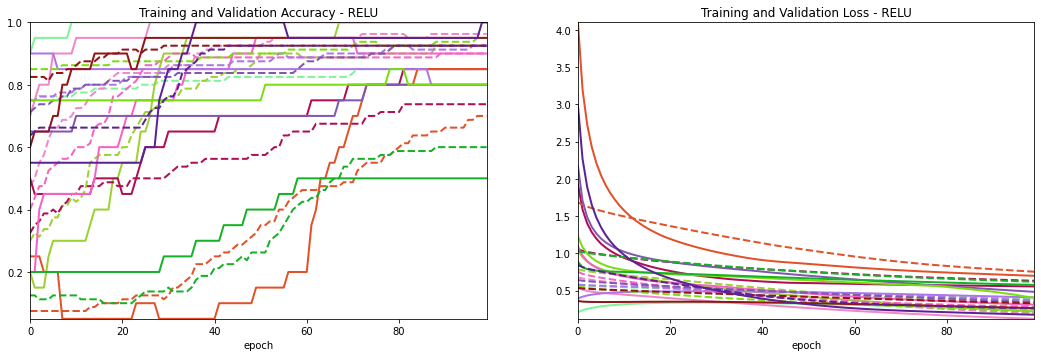

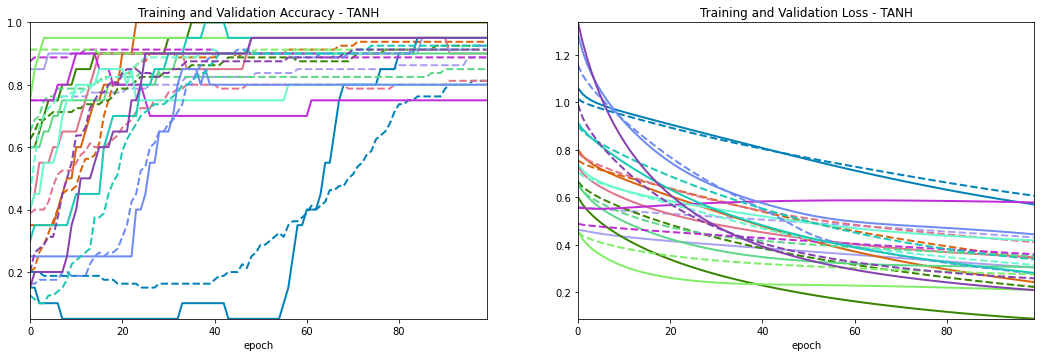

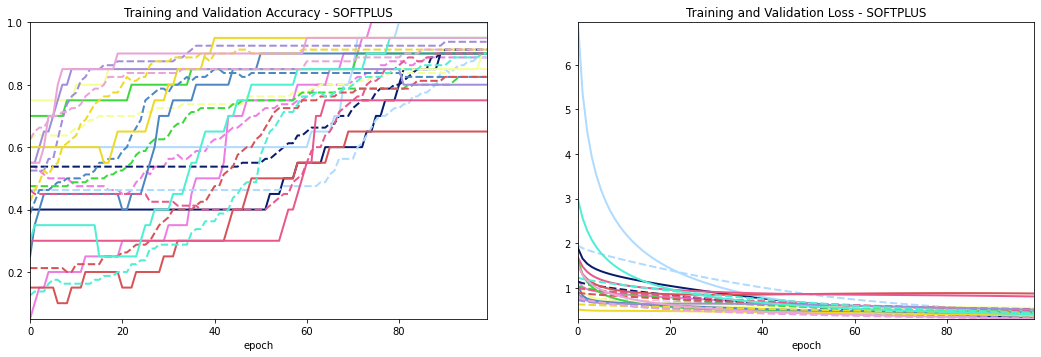

In [16]:
# Show a per epoch training history
def showTrainingHistory(title, histories):
    import randomcolor
    train_acc = [h.history('accuracy', mm.DataType.TRAIN) for h in histories]
    train_loss = [h.history('loss', mm.DataType.TRAIN) for h in histories]
    val_acc = [h.history('accuracy', mm.DataType.VALIDATION) for h in histories]
    val_loss = [h.history('loss', mm.DataType.VALIDATION) for h in histories]

    PB = mm.PlotBuilder().create_subplots(2, 2, fig_size=(18, 12))
    PB.set_options(color=randomcolor.RandomColor().generate(count=len(train_acc)) * 2)
    #PB.set_options(color=['b', 'g', 'y', 'r', 'b', 'g', 'y', 'r', 'b', 'y', 'r', 'b', 'y', 'r', 'b', 'y'])
    epoch = range(len(train_acc[0]))
    pb = mm.PlotBuilder()
    if len(train_acc) == 1:
        y_vals = [(train_acc[0], 'Training Accuracy'), (val_acc[0], 'Validation Accuracy')]
        PB.create_plot(title, (epoch, 'epoch'), *y_vals)
    else:
        PB.create_plot('Training and Validation Accuracy - ' + title, (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_acc, val_acc)])
        PB.create_plot('Training and Validation Loss - ' + title, (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_loss, val_loss)])
    PB.show()

showTrainingHistory('RELU', HISTORY.filter_histories(activation_L1='relu'))
showTrainingHistory('TANH', HISTORY.filter_histories(activation_L1='tanh'))
showTrainingHistory('SOFTPLUS', HISTORY.filter_histories(activation_L1='softplus'))

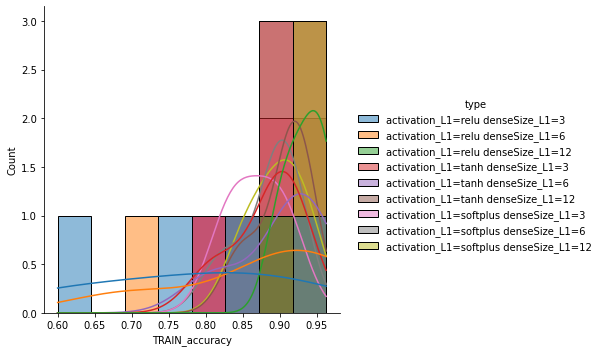

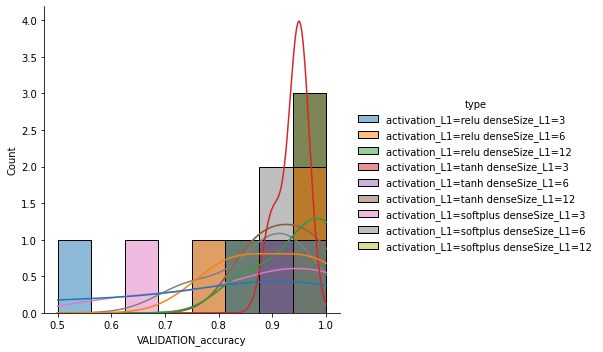

In [22]:
%autoreload
evaluation = mm.ModelEvaluation(HISTORY).set_filter_params(['activation_L1', 'denseSize_L1'])
evaluation.plot_distributions('accuracy', mm.DataType.TRAIN).plot_distributions('accuracy', mm.DataType.VALIDATION)